In [21]:
import socket
import nmap

def get_ip():
    """
    Returns the IP address of the adaptor that would route to
    an internet IP address, I think?
    
    from https://stackoverflow.com/a/60656570/8970017
    """
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    try:
        # doesn't even have to be reachable
        s.connect(('10.255.255.255', 1))
        ipaddr = s.getsockname()[0]
    except:
        ipaddr = '127.0.0.1'
    finally:
        s.close()
    return ipaddr

def scan_our_subnet(ouripaddr):
    """
    Scans x.x.x.* looking for port 5000 open
    """
    nm = nmap.PortScanner()
    searchips = '.'.join((ipaddr.split('.')[:3]+['*']))
    nm.scan(searchips,'22,5000',arguments='-T5')    
    return nm.analyse_nmap_xml_scan()['scan']

In [22]:
ipaddr = get_ip()
results = scan_our_subnet(ipaddr)

In [23]:
for addr, details in results.items():
    print("%30s | %7s | %7s" % (addr,details['tcp'][22]['state'],details['tcp'][5000]['state']))

                192.168.246.95 |    open |  closed
               192.168.246.112 |    open |    open
               192.168.246.159 |  closed |  closed


In [39]:
import os
for addr, details in results.items():
    if (details['tcp'][22]['state']=='open'):
        print("Downloading from %s" %  addr)
        os.system('rsync --rsh="sshpass -f pw.txt ssh -l pi" -z pi@%s:/home/pi/beephotos test -a' % addr)

rsync: connection unexpectedly closed (0 bytes received so far) [Receiver]
rsync error: error in rsync protocol data stream (code 12) at io.c(231) [Receiver=3.2.7]


In [58]:
session_name = 'session1'

import alignment.helper
import alignment
import numpy as np
from glob import glob
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline


#a helper function specific for this dataset that gets the time from the filename
def getsecondsfromfn(fn):
    """Get number of seconds since midnight from filename, returns float"""
    timestring = re.findall('([0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{6})',fn)[0]
    hours,mins,secs = [float(st) for st in timestring.split(':')]
    return hours*3600+mins*60+secs


paths = glob(f'test/beephotos/{session_name}/cal/*/*')

allimgfiles = [sorted(glob(path+'/*.np'))[:8] for path in paths]

#compute the start times of intervals
alltimes = []
for imgfiles in allimgfiles:
    for fn in imgfiles:
        alltimes.append(getsecondsfromfn(fn))

#get the interval start times
intervalstarts = alignment.helper.getintervalstarts(alltimes,interval_length=1)

allimages = []
allintervals = []
#loop through the cameras...
for imgi,imgfiles in enumerate(allimgfiles):
    images = []
    intervals = []
    #loop through our images...
    for fn in imgfiles:
        interval = alignment.helper.getinterval(getsecondsfromfn(fn),intervalstarts)
        data = np.load(fn,allow_pickle=True)
        images.append(data['img'].astype(float))
        intervals.append(interval)
    allimages.append(images)
    allintervals.append(intervals)

In [59]:
allintervals

[[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7]]

In [60]:
al = alignment.compute_orientation(allimages,allintervals)
alignment.helper.addmissingobs_timeinterval(al.photos) 

Failed to find cache file
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
Not in cache, decoding...
1282062.6997313064
592919.2083323776
341199.8503457899
215884.57502109234
148686.04346487997
3796.9199998540976
805.9491764622013
653.4904464277398
653.4904461196007


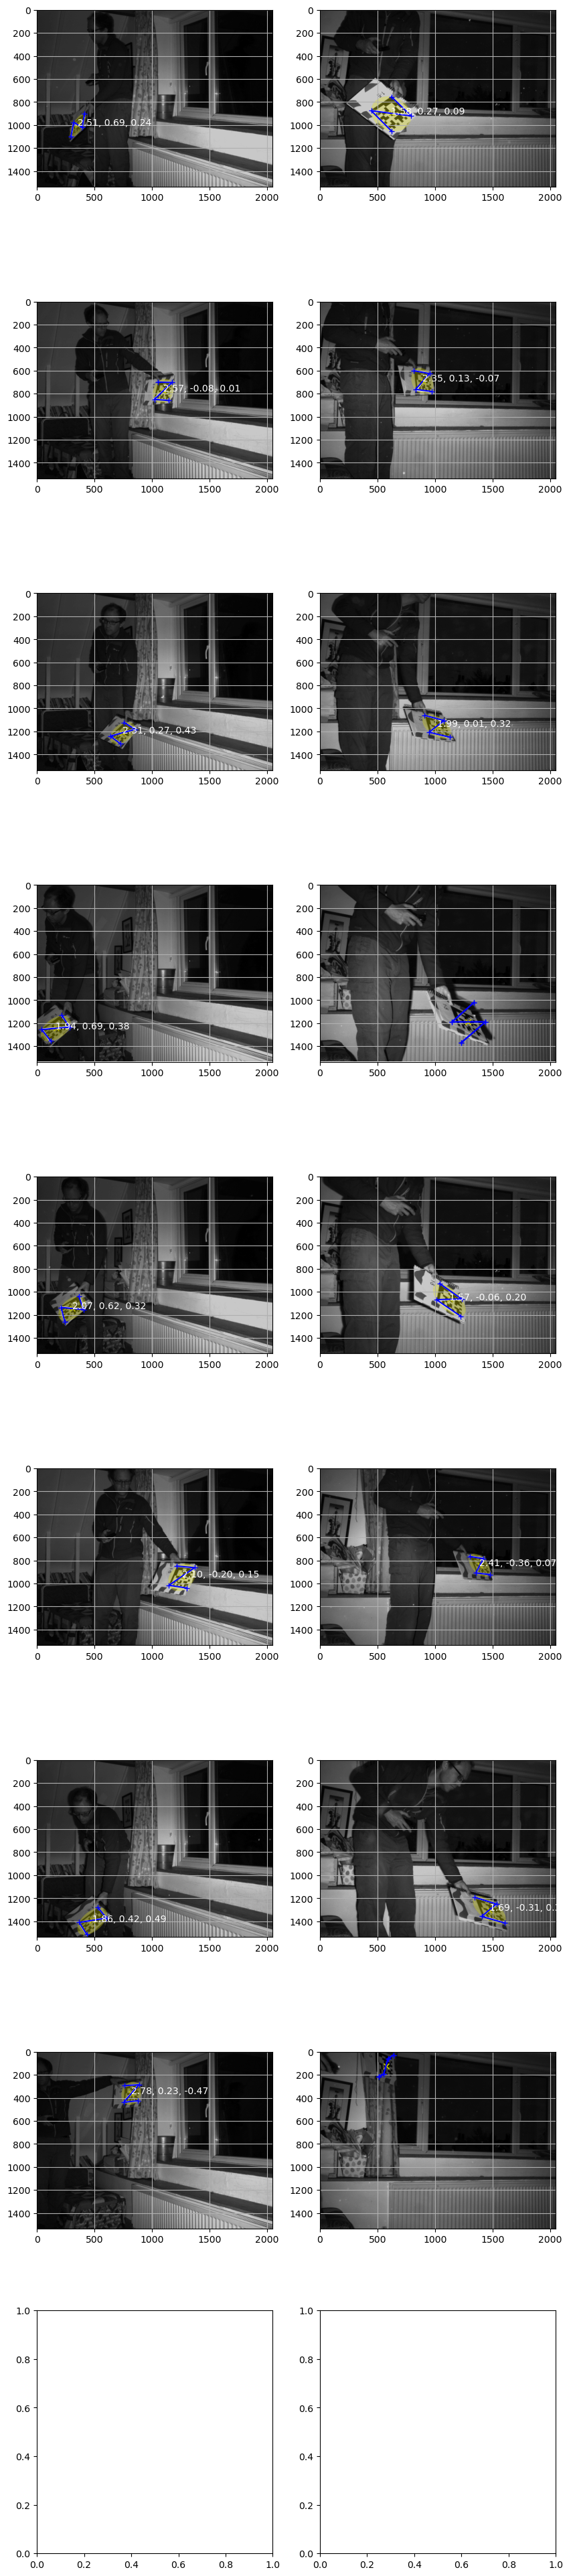

In [61]:
plt.figure(figsize=[10,50])
for i in range(len(intervalstarts)):
    for j in range(len(al.cameras)):
        plt.subplot(len(intervalstarts),len(al.cameras),i*len(al.cameras)+j+1)
        for photo in al.photos:
            if photo.camera == al.cameras[j]:
                if photo.timeindex == i:                
                    photo.draw()
                    plt.xlim([0,2048])
                    plt.ylim([1536,0]) 
                    plt.grid()